In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch

import numpy as np
import pandas as pd
import nn_blocks, idplots, ddpm, utils, inpaint, ground_truth

import data_utils, data_classes
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime

image_size = 64
channels = 1
batch_size=512
device = "cuda" if torch.cuda.is_available() else "cpu"

/Users/chadi/anaconda3/envs/diffusion_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare ground-truth for inpainting

In [2]:
# if True, take a training data sample as gt:
if False: 
    inpaintfrom_idx = 19
    gt_keep_mask = np.ones((channels,image_size,image_size))
    gt_keep_mask[:,inpaintfrom_idx:,:] = 0
    # mask is ones for the known pixels, and zero for the ones to be infered
    gt = data.getitem_nocast(4)
    print(gt.shape)
    show_tensor_image(gt, place=ipl)
    plt.show()

Restored git repo Flusight/FluSight-forecast-hub/
Spatial Setup with 51 locations.
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Checked out commit on 2023-10-04 00:00:00 (SHA: 7492a74610c174b72e8cd48a32f0a93b925c0692, 1696358371) for repo Flusight/FluSight-forecast-hub/
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Restored git repo Flusight/FluSight-forecast-hub/


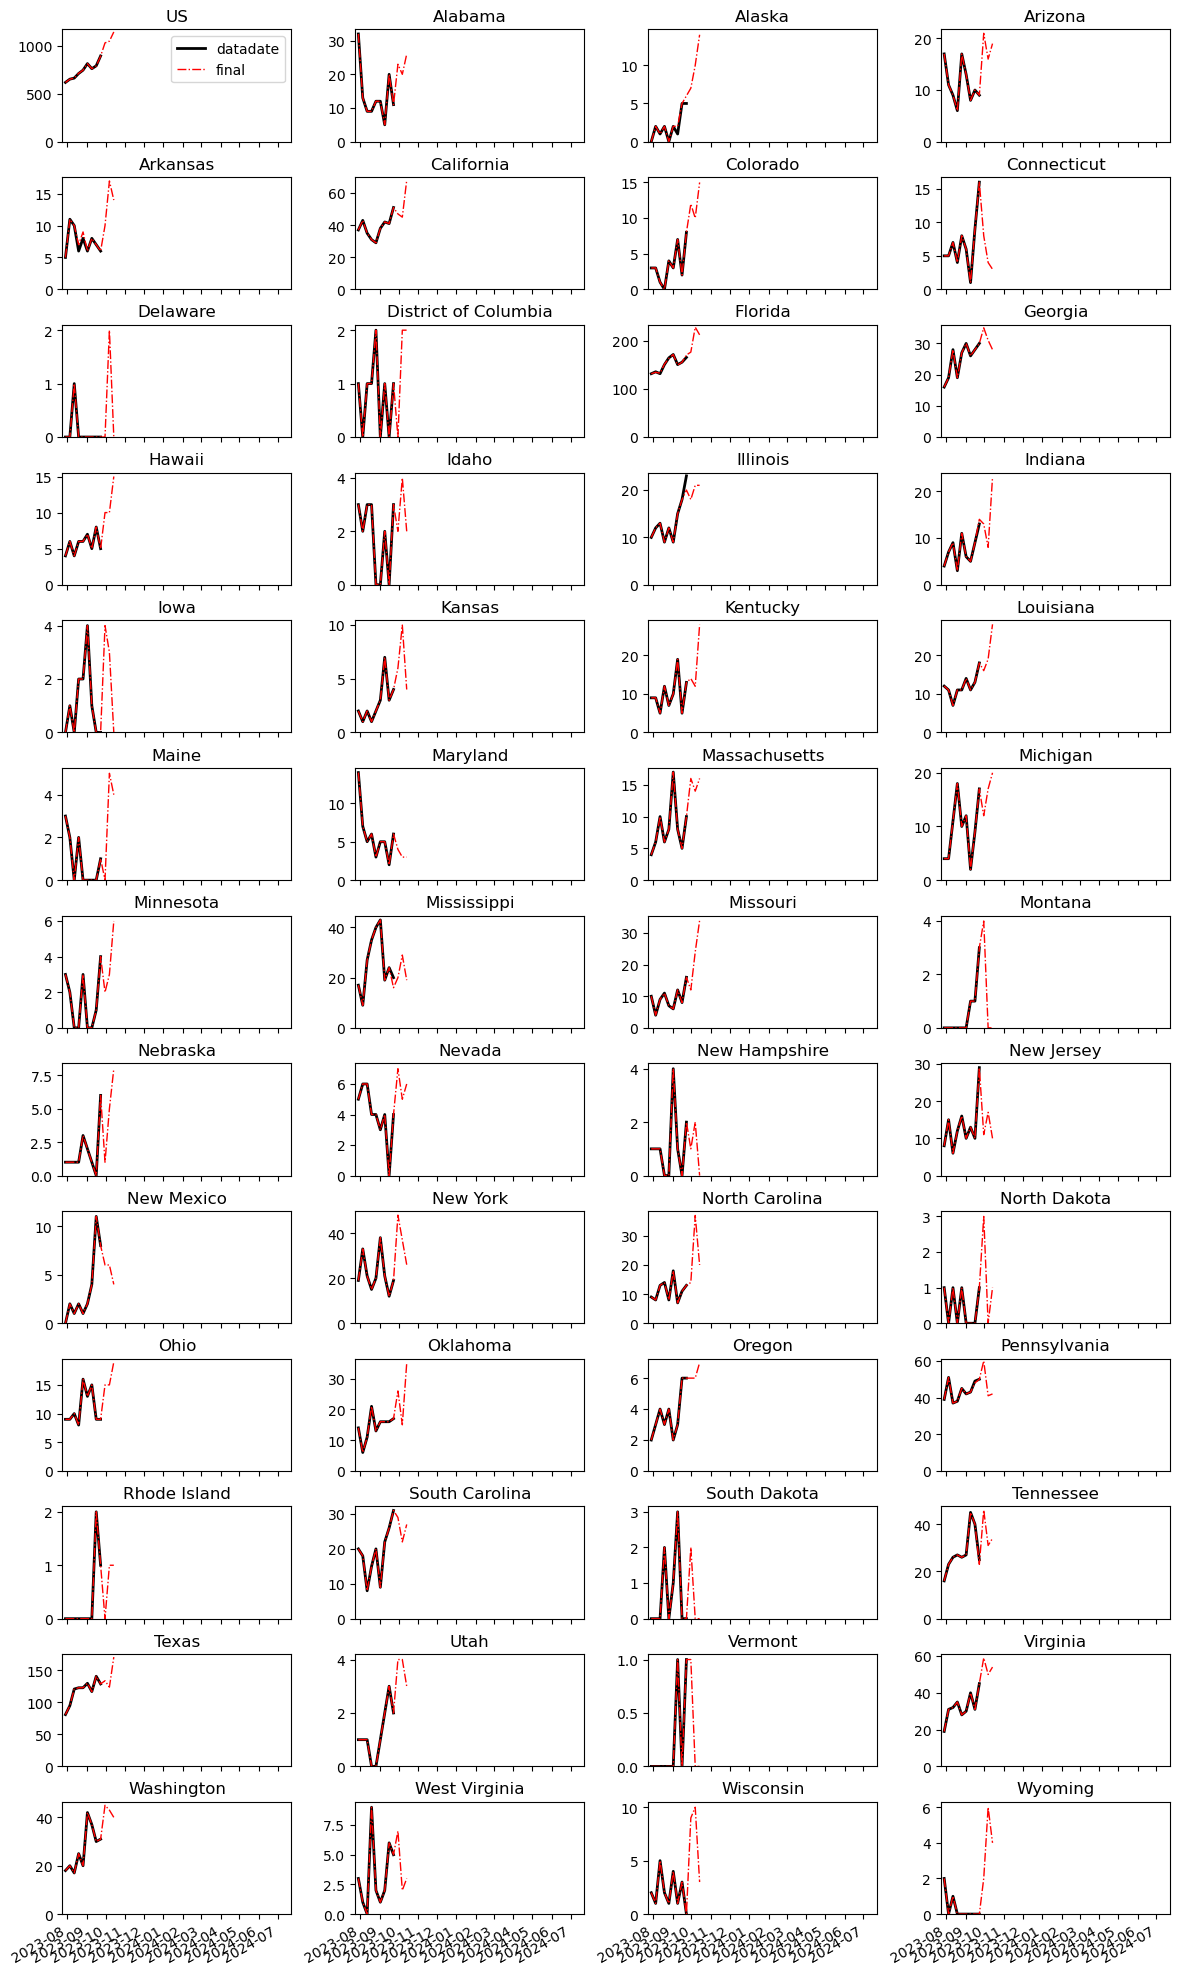

In [3]:
gt1 = ground_truth.GroundTruth(season_first_year="2023", 
                               data_date=datetime.datetime(2023,10,4), 
                               mask_date=datetime.datetime.today())
gt1.plot()

## Define a PyTorch Dataset + DataLoader

In [4]:
data = data_classes.FluDataset.from_fluview(
                                         flusetup=gt1.flusetup,
                                         download=False, 
                                         #transform=data_classes.transform_randomscale
                                         )
#data = data_classes.FluDataset.from_SMHR1_fluview(flusetup=gt1.flusetup, download=False)
data = data_classes.FluDataset.from_csp_SMHR1('Flusight/flu-datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc', channels=channels)
data.test(6)

created dataset with max [19.4177], full dataset has shape (13, 1, 64, 64)
created dataset with max [14603.53538403], full dataset has shape (1199, 1, 64, 64)
test passed: back and forth transformation are ok ✅


In [5]:
scaling_per_channel = np.sqrt(max(data.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])).data)
scaling_per_channel

array([120.84508837])

In [6]:
## define image transformations (e.g. using torchvision)

transform_enrich = transforms.Compose([
                        transforms.Lambda(lambda t: data_classes.transform_poisson(t)),
                        transforms.Lambda(lambda t: data_classes.transform_random_padintime(t, min_shift = -15, max_shift = 15)),
                        #transforms.Lambda(lambda t: data_classes.transform_randomscale(t, min=.1, max=1.9)),
        ])
#                         transforms.Lambda(lambda t: data_classes.transform_skewednoise(t, scale=.4, a=-1.8))
transform = transforms.Compose([
                        data_classes.transform_sqrt,
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),

        ])

# TODO: scaling on incident hops scale.

transform_inv = transforms.Compose([
                    data_classes.transform_sqrt_inv,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 2)),
        ][::-1])      # important reverse the sequence

In [7]:
data.add_transform(transform=transform, transform_inv=transform_inv, transform_enrich=transform_enrich, bypass_test=False)

test passed: back and forth transformation are ok ✅


In [8]:
sample = data[6]
print(f"There are {len(data)} samples in the dataset, and a single sample has shape {sample.shape}")

There are 1199 samples in the dataset, and a single sample has shape torch.Size([1, 64, 64])


In [9]:
# Dataset is shuffled, but the last incompleted batch is dropped
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True) 
batch = next(iter(dataloader))
print(f"batch shape {batch.shape}")

batch shape torch.Size([512, 1, 64, 64])


Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

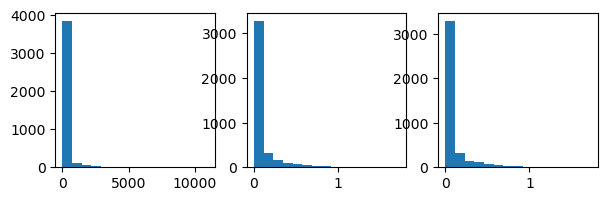

In [10]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes.flat[0].hist(data.get_sample_raw(4).flatten(), bins=15);
axes.flat[1].hist(data.get_sample_transformed(4).flatten(), bins=15);
axes.flat[2].hist(data.get_sample_transformed_enriched(4).flatten(), bins=15);

In [11]:
# fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100, sharex=True, sharey=True)
# for ipl in range(51):
#     ax = axes.flat[ipl]
#     for i in range(batch_size):
#         ax.plot(batch[i][0][:,ipl], lw=0.5)

## Initialize the DDPM class

In [12]:
model = nn_blocks.Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)

ddpm1 = ddpm.DDPM(model=model, 
                    image_size=image_size, 
                    channels=channels, 
                    batch_size=batch_size, 
                    epochs=3, 
                    timesteps=200,
                    device=device)


## Forward diffusion sample

batch shape torch.Size([512, 1, 64, 64])
California


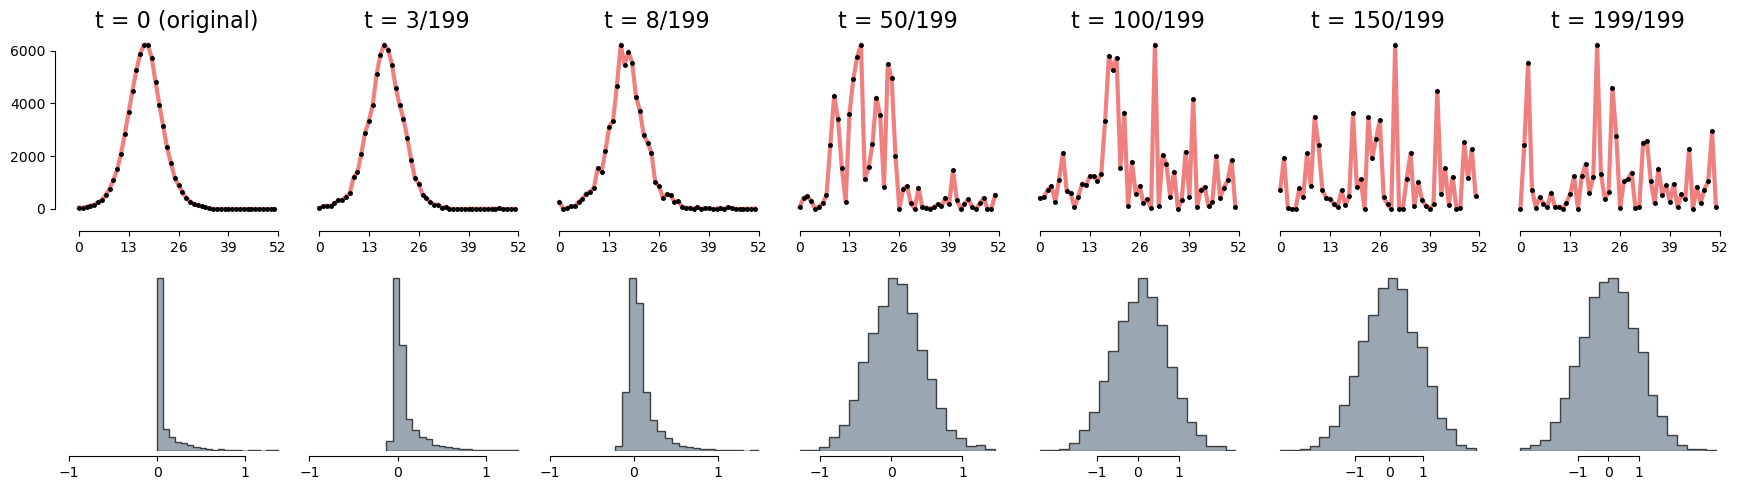

In [15]:
# use seed for reproducability
torch.manual_seed(0)
x_start = next(iter(dataloader))
print(f"batch shape {batch.shape}")

def plot(imgs, row_title=None, col_title=None, with_histogram=True, plot_size=2, **imshow_kwargs): # with_orig=False,
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    
    mult_rows=1
    if with_histogram:
        mult_rows=2

    place = 4
    color="lightcoral"#'slategray'
    print(gt1.flusetup.get_location_name(gt1.flusetup.locations[place]))
    
    num_rows = len(imgs)*mult_rows
    num_cols = len(imgs[0]) #+ with_orig
    fig, axs = plt.subplots(figsize=(plot_size*num_cols,plot_size*num_rows), nrows=num_rows, ncols=num_cols, squeeze=False, dpi=100)
    for row_idx, row in enumerate(imgs):
        # row = [transform_inv(a[place,:])] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx*mult_rows, col_idx]
            ax.plot(np.arange(52), transform_inv(np.asarray(img))[0,:52,place], **imshow_kwargs, color=color, lw=3, marker='.', markersize=5, markerfacecolor='black', markeredgecolor='black')
            ax.set_xticks(np.arange(0,53,13))
            sns.despine(ax = ax,  offset = 10, trim = True)
            if col_idx>0:
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 10, left=True, trim = True)

            
            #ax.set_ylim(0)
            #ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if with_histogram:
                ax = axs[row_idx*mult_rows+1, col_idx]
                ax.hist(np.asarray(img).flatten(), bins=20, color='slategray', alpha=0.7, lw=1, edgecolor='k', histtype='stepfilled')
                ax.set_xticks([-1,0,1])
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 4, left=True, trim = True)
            

    #if with_orig:
    #    axs[0, 0].set(title='Original')
    #    axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    if col_title is not None:
        for col_idx in range(num_cols):
            axs[0, col_idx].set(title=col_title[col_idx])
            axs[0, col_idx].title.set_size(16)

    plt.tight_layout()

#diffused_curves = [[q_sample(x_start[7,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]] ,
#                   [q_sample(x_start[9,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]]]#
#plot(diffused_curves, with_histogram=True)

def plot_foward_diffusion(x_start, ts, with_histogram=True, plot_size=2, **imshow_kwargs):
    if not isinstance(x_start, list):
        # Make a 2d grid even if there's just 1 row
        x_start = [x_start]
    diffused_curves = [[x] + [ddpm1.q_sample(x, torch.tensor([t])) for t in ts] for x in x_start]
    col_title = ['t = 0 (original)'] + [f't = {t}/{ddpm1.timesteps-1}' for t in ts]

    plot(diffused_curves, with_histogram=with_histogram, plot_size=plot_size, col_title=col_title, **imshow_kwargs)


plot_foward_diffusion([x_start[0,:]], ts=[3,8, 50, 100, 150, 199], with_histogram=True, plot_size= 2.5)

This means that we can now define the loss function given the model as follows:

## Train the model


In [ ]:
ddpm1.train(dataloader=dataloader)

/!\ training on cpu
Epoch: 0    -- Loss: 0.4821333885192871
Epoch: 1    -- Loss: 1.0372872352600098
Epoch: 2    -- Loss: 0.548339307308197


## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [ ]:
if ddpm1.device == "cuda":
    print(utils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(utils.cuda_mem_info())

In [ ]:
# sample 64 images
samples = ddpm1.sample()

sampling loop time step:  16%|█▋        | 33/200 [10:19<52:16, 18.78s/it] 


KeyboardInterrupt: 

In [ ]:
# show a random one
random_index = 0
#plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels))

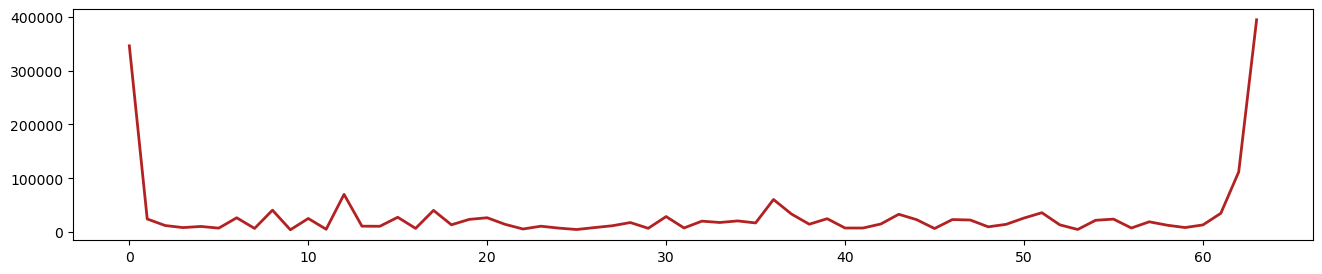

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
idplots.show_tensor_image(data.apply_transform_inv(samples[-1][random_index]), ax = ax)
plt.show()

NameError: name 'samples' is not defined

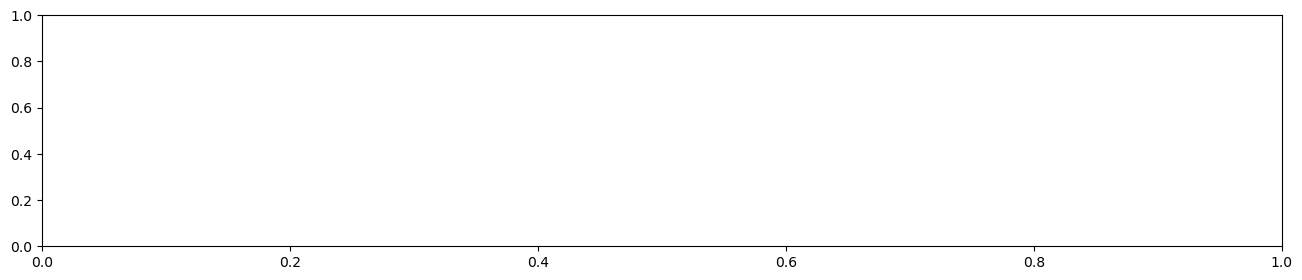

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
for i in range(batch_size):
    idplots.show_tensor_image(data.apply_transform_inv(samples[-1][i]), ax = ax)
#ax.set_ylim(0,10000)

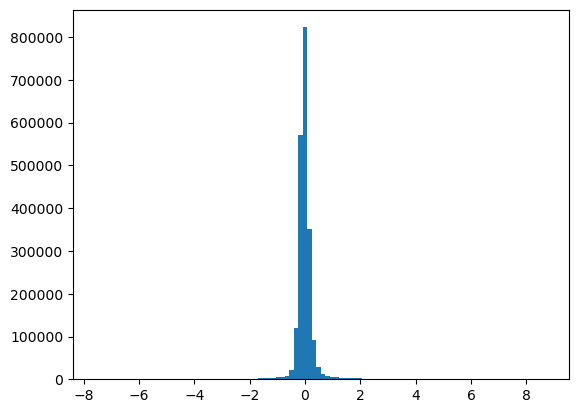

In [ ]:
plt.hist(samples[-1].flatten(), bins = 100);

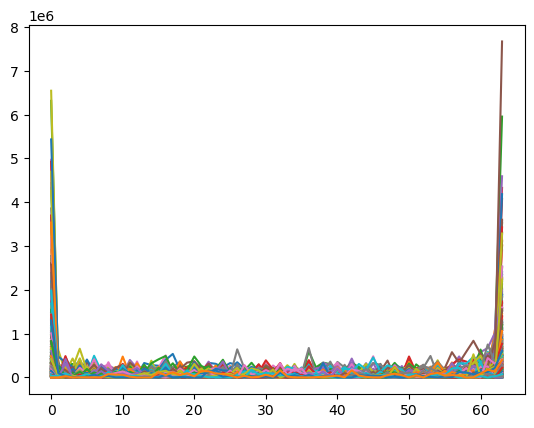

In [ ]:
plt.plot(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).T);

(array([131.,  97.,  65.,  49.,  36.,  26.,  18.,  14.,  16.,  13.,   3.,
          5.,   8.,  11.,   3.,   1.,   4.,   2.,   2.,   3.,   0.,   1.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([  88787.25400033,  341484.76901766,  594182.28403499,
         846879.79905231, 1099577.31406964, 1352274.82908697,
        1604972.34410429, 1857669.85912162, 2110367.37413895,
        2363064.88915628, 2615762.4041736 , 2868459.91919093,
        3121157.43420826, 3373854.94922559, 3626552.46424291,
        3879249.97926024, 4131947.49427757, 4384645.0092949 ,
        4637342.52431222, 4890040.03932955, 5142737.55434688,
        5395435.06936421, 5648132.58438153, 5900830.09939886,
        6153527.61441619, 6406225.12943352, 6658922.64445084,
        6911620.15946817, 7164317.6744855 , 7417015.18950283,
        7669712.70452015]),
 <BarContainer object of 30 artists>)

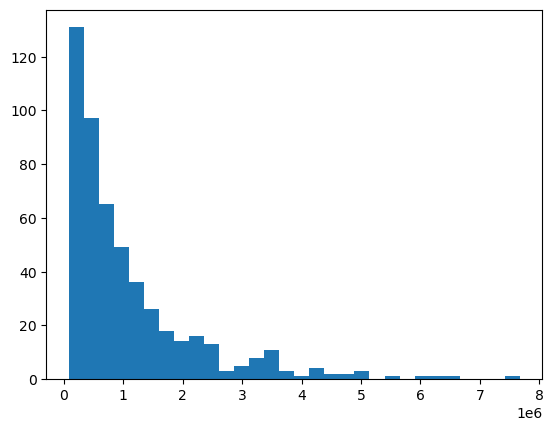

In [ ]:
# histogram of peaks. In the US historically it's from 13k to 34k
plt.hist(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).max(axis=1), bins=30)

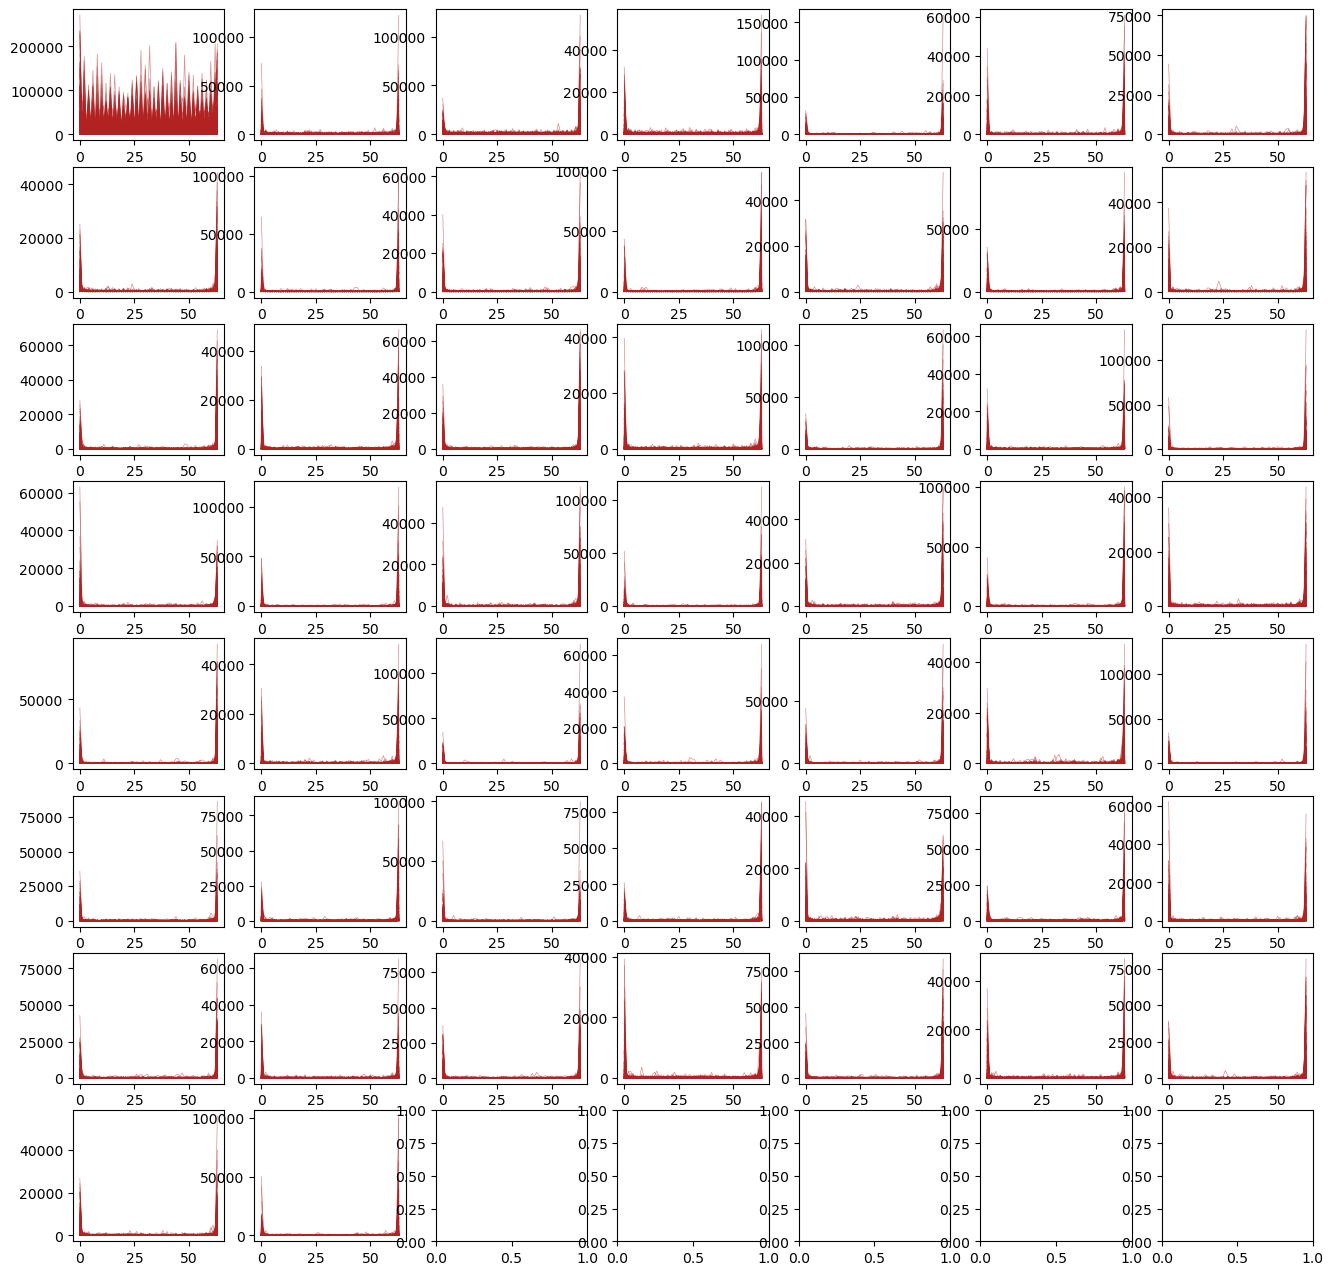

In [ ]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100)

for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(batch_size):
        idplots.show_tensor_image(data.apply_transform_inv(samples[-1][i]), ax = ax, place=ipl, multi=True)


In [ ]:
animate = False
if animate:
    import matplotlib.animation as animation

    random_index = 53
# TODO: the reshape shuffles the information
    fig = plt.figure()
    ims = []
    for i in range(ddpm1.timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save('diffusion.gif')
    plt.show()

In [ ]:
if animate:
    plt.ioff()
    for ts in tqdm(range(0, ddpm1.timesteps, 5)):
        fig, axes = plt.subplots(8, 8, figsize=(10,10))
        for ipl in range(51):
            ax = axes.flat[ipl]
            for i in range(0,batch_size, 2):
                idplots.show_tensor_image(data.apply_transform_inv(samples[ts][i]), ax = ax, place=ipl)
        plt.savefig(f'results/{ts}.png')
        plt.close(fig)

## Let's add repainting from the RePaint paper

Dimensions are chanel, time, place

In [ ]:
transform_notdesc = transforms.Compose([
                    data_classes.transform_sqrt,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),
                    #transforms.Lambda(lambda t: data_classes.transform_random_rollintime(t, max_shift = 20)),
        ])

In [ ]:
gt = transform_notdesc(gt_xarr.data) # data.apply_transform
print(gt.shape)

(1, 64, 64)


In [ ]:
device = next(model.parameters()).device
gt_keep_mask = torch.from_numpy(gt_keep_mask).type(torch.FloatTensor).to(device)
gt = torch.from_numpy(gt).type(torch.FloatTensor).to(device)

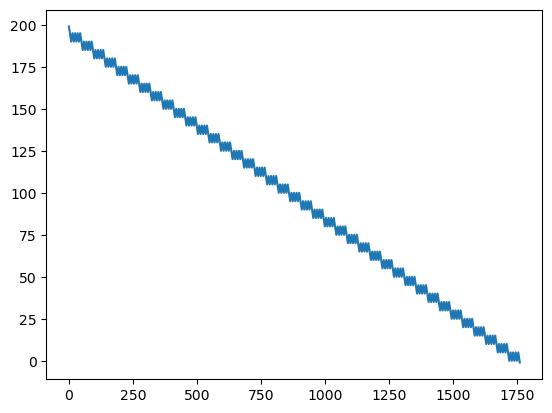

In [ ]:
# schedule with J
t_T = ddpm1.timesteps
jump_len = 5 
jump_n_sample = 5 
jumps = {} 
for j in range(0, t_T - jump_len, jump_len): 
  jumps[j] = jump_n_sample - 1 
t = t_T 
ts = []
while t >= 1: 
  t = t-1
  ts.append(t) 
  if jumps.get(t, 0) > 0: 
   jumps[t] = jumps[t] - 1 
   for _ in range(jump_len): 
     t=t+1 
     ts.append(t)
ts.append(-1)
plt.plot(ts)

In [ ]:
if device == "cuda":
    print(utils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(utils.cuda_mem_info())

In [ ]:
from importlib import reload
inpaint = reload(inpaint)
inpaint1 = inpaint.REpaint(ddpm=ddpm1,gt=gt, gt_keep_mask=gt_keep_mask)

In [ ]:
n_samples = batch_size
all_samples = []
for i in range(max(n_samples//batch_size,1)):
    samples = inpaint1.sample_paint()
    all_samples.append(samples)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
fluforecasts = -1*np.ones((batch_size*max(n_samples//batch_size,1), 1, 64, 64))
for i in range(max(n_samples//batch_size,1)):
    fluforecasts[i*batch_size:i*batch_size+batch_size] = all_samples[i][-1]

NameError: name 'show_tensor_image' is not defined

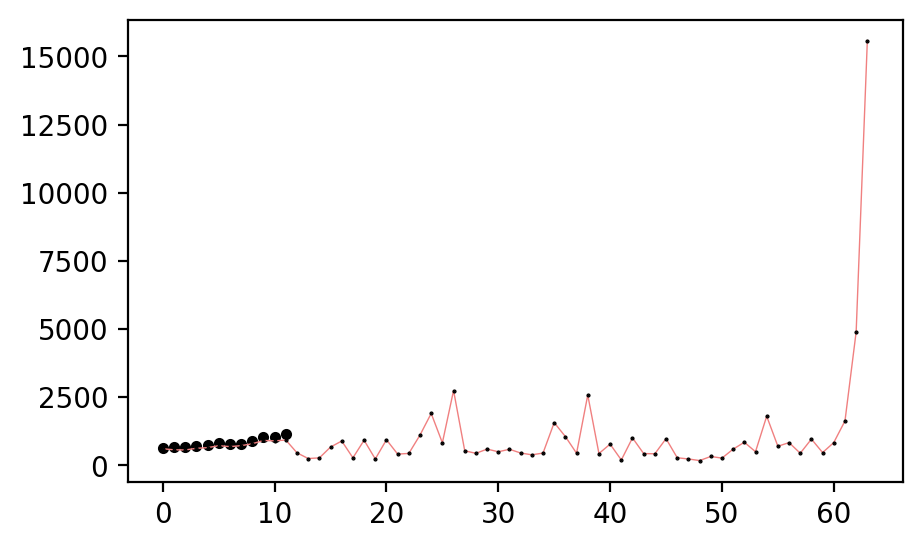

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=200)

ax = axes
for i in range(batch_size)[::2]:
    ax.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
    ax.plot(data.apply_transform_inv(samples[-1][i])[0].sum(axis=1) , lw=.5, marker='.', markersize=1, markerfacecolor='black', markeredgecolor='black', color="lightcoral")
    idplots.show_tensor_image(samples[-1][i], ax = ax, multi=True,)
    ax.axvline(inpaintfrom_idx-1,  c='k', lw=1, ls='-.')
    ax.set_xlim(0,52)
    #ax.set_ylim(bottom=0, auto=True)
    #ax.grid(visible = True)
    ax.set_title("National")
    sns.despine(ax = ax, trim = True, offset=4)
fig.tight_layout()
plt.show()

In [ ]:
#fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=200, sharex=True)

#for ipl in range(51):
#    ax = axes.flat[ipl]
#    for i in range(min(50, batch_size)):  # print max 50 sims
#        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color='k')
#        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)
#        ax.axvline(inpaintfrom_idx-1, c='k', lw=.7, ls='-.')
#        ax.set_xlim(0,52)
#        ax.set_ylim(bottom=0, auto=True)
#        ax.grid()
#        #ax.set_title(get_state_name(places[ipl]))
#fig.tight_layout()
##plt.savefig("inpainting.pdf")

In [ ]:

fluforecasts.shape

In [ ]:

flusight_quantile_pairs                             

In [ ]:
fluforecasts_ti = data.apply_transform_inv(fluforecasts)

In [ ]:
plt.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=-1))

In [ ]:
plt.hist(np.random.normal(loc=1, scale=.4, size=1000))

In [ ]:
fluforecasts_ti = data.apply_transform_inv(fluforecasts)


# compute the national quantiles, important as sum of quantiles >> quantiles of sum
forecasts_national = fluforecasts_ti.sum(axis=-1)
forecasts_national.shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=100)

for iax in range(2):
  ax = axes[iax]
  for iqt in range(11):
      #print(flusight_quantile_pairs[iqt,0], flusight_quantile_pairs[iqt,1])
      ax.fill_between(np.arange(64), 
                      np.quantile(forecasts_national, flusight_quantile_pairs[iqt,0], axis=0)[0], 
                      np.quantile(forecasts_national, flusight_quantile_pairs[iqt,1], axis=0)[0], alpha=.1, color='darkred')
      
  ax.plot(np.arange(64), 
          np.quantile(forecasts_national, flusight_quantiles[12], axis=0)[0], color='r')
  #ax.plot(np.arange(64), fluforecasts_ti[:,0].sum(axis=-1).T,lw=0.1, alpha=.1,  color='k')
  ax.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
  ax.axvline(inpaintfrom_idx-1, c='k')
  if iax==0:
    ax.set_xlim(0,52)
    ax.set_ylim(bottom=0, auto=True)
  if iax==1:
    ax.set_xlim(inpaintfrom_idx-4,inpaintfrom_idx+4)
    ax.set_ylim(bottom=0, top=1500)
  
  ax.grid(visible = True)
  ax.set_title("National")
fig.tight_layout()
plt.show()

In [ ]:
forecast_date = datetime.date(2023,5,15)
team_abbrv = "UNC_IDD-InfluPaint"

In [ ]:
gt_xarr.data[0,:inpaintfrom_idx, ipl][10:52].shape

In [ ]:
idx_now = inpaintfrom_idx-1
idx_horizon = idx_now+4

plot_specs = {"all" : {
                      "quantiles_idx":range(11),
                      "color":"lightcoral",
                      },
              "50-95" : {
                      "quantiles_idx":[1, 6],
                      "color":"darkblue"
                        }
            }

color_gt = "black"

nplace_toplot = 51
#nplace_toplot = 3 # less plots for faster iteration
plot_past_median = False
if plot_past_median:
  plotrange=slice(None)
else:
  plotrange=slice(inpaintfrom_idx,-1)

for plot_title, plot_spec in plot_specs.items():
  #print(f"doing {plot_title}...")
  fig, axes = plt.subplots(nplace_toplot+1, 2, figsize=(10,nplace_toplot*3.5), dpi=200)
  
  for iax in range(2):
    ax = axes[0][iax]

    x = np.arange(64)
    if iax == 0:
      x_lims = (0, 52)
    elif iax == 1:
      x_lims = (idx_now-3, idx_horizon)

    # US WIDE: quantiles and median, US-wide
    for iqt in plot_spec["quantiles_idx"]:
        #print(f"up: {flusight_quantile_pairs[iqt,0]} - lo: {flusight_quantile_pairs[iqt,1]}")
        # TODO: not exactly true that it is the sum of quantiles (sum of quantile is not quantile of sum)
        ylo = np.quantile(forecasts_national, flusight_quantile_pairs[iqt,0], axis=0)[0]
        yup = np.quantile(forecasts_national, flusight_quantile_pairs[iqt,1], axis=0)[0]
        ax.fill_between(x[plotrange], 
                        ylo[plotrange], 
                        yup[plotrange], 
                        alpha=.1, 
                        color=plot_spec["color"])
        
         # widest quantile pair is the first one. We take the up quantile of it + a few % as x_lim
        if iqt == plot_spec["quantiles_idx"][0]:
          if plot_past_median:
              max_y_value = max(yup[x_lims[0]:x_lims[1]])
          else:
              max_y_value = max(yup[inpaintfrom_idx:x_lims[1]])
          max_y_value = max(max_y_value, gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1)[x_lims[0]:x_lims[1]].max())
          max_y_value = max_y_value + max_y_value*.05 # 10% more

    # median
    ax.plot(x[plotrange], np.quantile(forecasts_national, flusight_quantiles[12], axis=0)[0][plotrange], color=plot_spec["color"], marker='.', label='forecast median')

    # ground truth
    ax.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1), color=color_gt, marker = '.', lw=.5, label='ground-truth')
    if iax==0:
      ax.legend(fontsize=8)

    #ax.set_xticks(np.arange(0,53,13))
    
  
    ax.set_xlim(x_lims)
    ax.set_ylim(bottom=0, top=max_y_value)
    ax.axvline(idx_now, c='k', lw=1, ls='-.')
    if iax == 0:
      ax.axvline(idx_horizon, c='k', lw=1, ls='-.')
    ax.set_title("National")
    
    sns.despine(ax = ax, trim = True, offset=4)

    # INDIVDIDUAL STATES: quantiles, median and ground-truth
    max_y_value = np.zeros(52)
    for iqt in plot_spec["quantiles_idx"]:
        yup = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,0], axis=0)[0]
        ylo = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,1], axis=0)[0]
        
        # widest quantile pair is the first one. We take the up quantile of it + a few % as x_lim
        if iqt == plot_spec["quantiles_idx"][0]:
          for ipl in range(nplace_toplot):
            if plot_past_median:
              max_y_value[ipl] = max(ylo[x_lims[0]:x_lims[1], ipl])
            else:
              max_y_value[ipl] = max(ylo[inpaintfrom_idx:x_lims[1], ipl])
            #max_y_value[ipl] =  max(ylo[x_lims[:x_lims[1], ipl])
            max_y_value[ipl] = max(max_y_value[ipl], gt_xarr.data[0,:inpaintfrom_idx, ipl][x_lims[0]:x_lims[1]].max())
            max_y_value[ipl] = max_y_value[ipl] + max_y_value[ipl]*.05 # 10% more for the y_max value

        for ipl in range(nplace_toplot):
            ax = axes[ipl+1][iax]
            ax.fill_between((x)[plotrange],  (yup[:,ipl])[plotrange], (ylo[:,ipl])[plotrange], alpha=.1, color=plot_spec["color"])
    
    # median line and ground truth for states
    for ipl in range(nplace_toplot):   
        ax = axes[ipl+1][iax]
        # median
        ax.plot(np.arange(64)[plotrange],
                np.quantile(fluforecasts_ti, flusight_quantiles[12], axis=0)[0,:,ipl][plotrange], color=plot_spec["color"], marker = '.', lw=.5)
        # ground truth
        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color=color_gt, marker = '.', lw=.5)

        ax.axvline(idx_now, c='k', lw=1, ls='-.')
        if iax == 0:
          ax.axvline(idx_horizon, c='k', lw=1, ls='-.')
        ax.set_xlim(x_lims)
        ax.set_ylim(bottom=0, top=max_y_value[ipl])
        if iax==0: ax.set_ylabel("New Hosp. Admissions")
        ax.set_title(gt1.flusetup.get_location_name(flusetup.locations[ipl]))
        sns.despine(ax = ax, trim = True, offset=4)
  fig.tight_layout()
  plt.savefig(f"{team_abbrv}-{forecast_date_str}-plot{plot_title}.pdf")

## Data Export

In [ ]:
import requests
requests.post("https://ntfy.sh/chadi_modeling",
     data="Notebook finshed running !",
     headers={
         "Title": "Inpainting-diffusion",
         "Priority": "urgent",
         "Tags": "warning,tada"
     })